In [7]:
from air_hockey_challenge.framework.air_hockey_challenge_wrapper import AirHockeyChallengeWrapper
from air_hockey_challenge.framework.challenge_core import ChallengeCore
from examples.control.hitting_agent import build_agent

from mushroom_rl.utils.dataset import parse_dataset, select_random_samples
from mushroom_rl.policy import GaussianTorchPolicy

import torch
import torch.nn as nn

from tqdm import tqdm

import pickle

import numpy as np


print("test")


use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(use_cuda)

test
True


In [2]:
class Network(nn.Module):
    def __init__(self, input_shape, output_shape, n_features, **kwargs):
        super(Network, self).__init__()

        self._h1 = nn.Linear(input_shape[0], n_features)
        self._h2 = nn.Linear(n_features, n_features)
        self._h3 = nn.Linear(n_features, output_shape[0])

        nn.init.xavier_uniform_(self._h1.weight,
                                gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self._h2.weight,
                                gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self._h3.weight,
                                gain=nn.init.calculate_gain('linear'))

    def forward(self, obs, **kwargs):
        features1 = torch.tanh(self._h1(torch.squeeze(obs, 1).float()))
        features2 = torch.tanh(self._h2(features1))
        return self._h3(features2)

policy = GaussianTorchPolicy(Network, (12,), (6,), std_0=1., n_features=64, use_cuda=use_cuda)

In [3]:
env = "3dof-hit"

mdp = AirHockeyChallengeWrapper(env)
mdp.reset()

agent = build_agent(mdp.env_info)
core = ChallengeCore(agent, mdp)

n_expert_traj = 500

dataset = []
success_traj = 0
for i in tqdm(range(n_expert_traj)):
    new_traj = core.evaluate(n_episodes=1) #initial_states=mdp.base_env._obs.copy()
    _, _, _, _, absorbed, _ = parse_dataset(new_traj)
    if absorbed[-1]: # we do not want examples where the "expert" did not score
        dataset += new_traj
        success_traj += 1

100%|██████████| 500/500 [12:06<00:00,  1.45s/it]


In [4]:
print(f"Dataset size: {len(dataset)} from {success_traj} trajectories")

dataset_path = f'dataset/hit_{n_expert_traj}.pkl'

with open(dataset_path, 'wb') as f:
    pickle.dump(dataset, f)

Dataset size: 53840 from 424 trajectories


In [ ]:
from air_hockey_challenge.utils.replay_dataset import replay_dataset
replay_dataset(env, dataset_path)

In [20]:
def train_bc(policy, dataset, n_epochs, batch_size, lr=0.0005):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    
    pbar = tqdm(range(n_epochs), desc='Epoch')
    logs = dict(loss=[], epoch=[])
    for iter in pbar:
        states, actions, rewards, next_states, absorbing, last  = select_random_samples(dataset, batch_size, parse=True)
        states_t = torch.from_numpy(states).to(device)
        expert_actions_t = torch.from_numpy(actions.reshape((batch_size,-1))).to(device)
        
        optimizer.zero_grad()
        loss = -policy.log_prob_t(states_t, expert_actions_t).mean()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'loss': loss.item()})
        logs['loss'].append(loss.item())
        logs['epoch'].append(iter)
    return logs

In [21]:

dataset = np.load("dataset/hit_500.pkl", allow_pickle=True)

logs = train_bc(policy, dataset, 100, 50)

Epoch: 100%|██████████| 100/100 [00:02<00:00, 43.25it/s, loss=5.3]


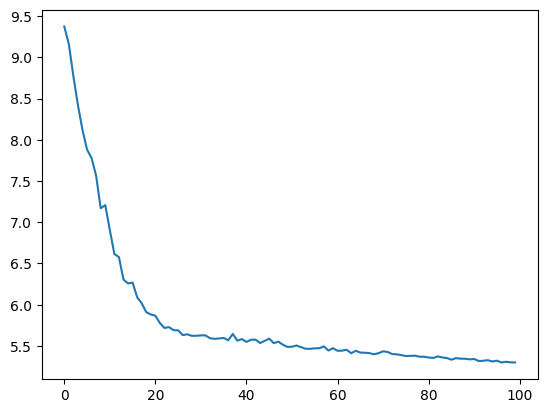

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(logs['epoch'], logs['loss'])